In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install wheel setuptools pip --upgrade
!pip install swig
!pip install pyvirtualdisplay xvfbwrapper gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5009 sha256=9e235e64eaeacf9da95952929f3e4b1112e9e6d69563de98e4ce54f81cfbd57b
  Stored in directory: /root/.cache/pip/wheels/cb/10/7d/2b7fdffccf837f7d5425931575fbee9caebe2c190931f9058b
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373071 sha256=2ebf220303639a59038c93c17b428f09400681ff8a7668349a8b86b92d97b842
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built xvfbwrapper box2d-py


In [3]:
!sudo apt-get update
!sudo apt-get install xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,279 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,259 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,152 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [969 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu

## **1- Import Packages**

In [4]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf


from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [5]:
%cd /content/drive/MyDrive/coursera/Unsupervised Learning/Reinforcement Learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/content/drive/MyDrive/coursera/Unsupervised Learning/Reinforcement Learning


In [6]:
%run utils.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
# tf.random.set_seed(utils.SEED)
tf.random.set_seed(2)

#**2- Hyperparameters**

In [8]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#**Lunar Lander Environment**

In this notebook we will be using OpenAI's Gym Library. The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved. In this notebook, we will try to solve the Lunar Lander environment using reinforcement learning.


3.1 Action Space
The agent has four discrete actions available:

Do nothing.
Fire right engine.
Fire main engine.
Fire left engine.
Each action has a corresponding numerical value:

Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3

3.2 Observation Space
The agent's observation space consists of a state vector with 8 variables:

Its  (𝑥,𝑦)
  coordinates. The landing pad is always at coordinates  (0,0)
 .
Its linear velocities  (𝑥˙,𝑦˙)
 .
Its angle  𝜃
 .
Its angular velocity  𝜃˙
 .
Two booleans,  𝑙
  and  𝑟
 , that represent whether each leg is in contact with the ground or not.

3.3 Rewards
After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.
is increased/decreased the slower/faster the lander is moving.
is decreased the more the lander is tilted (angle not horizontal).
is increased by 10 points for each leg that is in contact with the ground.
is decreased by 0.03 points each frame a side engine is firing.
is decreased by 0.3 points each frame the main engine is firing.
The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.


3.4 Episode Termination
An episode ends (i.e the environment enters a terminal state) if:

The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

The absolute value of the lander's  𝑥
 -coordinate is greater than 1 (i.e. it goes beyond the left or right border)

You can check out the Open AI Gym documentation for a full description of the environment.

#**4- Load the Environment**
We start by loading the LunarLander-v2 environment from the gym library

In [9]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


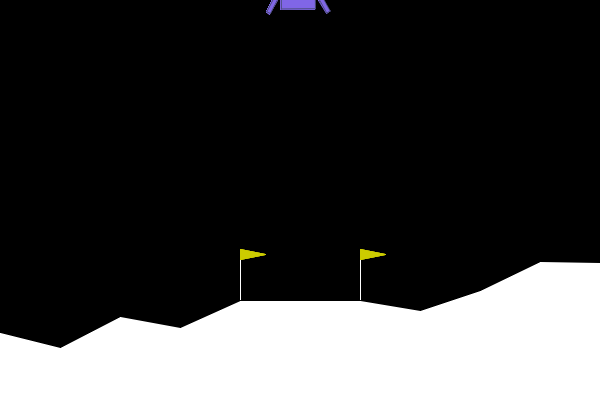

In [10]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [11]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


# **5- Interacting with the Gym Environment**

**Exploring the Environment's Dynamics**

In Open AI's Gym environments, we use the .step() method to run a single time step of the environment's dynamics. In the version of gym that we are using the .step() method accepts an action and returns four values:


*   observation (object): an environment-specific object representing your observation of the environment. In the Lunar Lander environment this corresponds to a numpy array containing the positions and velocities of the lander as described in section 3.2 Observation Space.
*   reward (float): amount of reward returned as a result of taking the given action. In the Lunar Lander environment this corresponds to a float of type numpy.float64 as described in section 3.3 Rewards.
*   done (boolean): When done is True, it indicates the episode has terminated and it’s time to reset the environment.
*   info (dictionary): diagnostic information useful for debugging. We won't be using this variable in this notebook but it is shown here for completeness.

To begin an episode, we need to reset the environment to an initial state. We do this by using the .reset() method.

In [12]:
# Reset the environment and get the initial state.
current_state = env.reset()

Once the environment is reset, the agent can start taking actions in the environment by using the .step() method. Note that the agent can only take one action per time step.

In the cell below you can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

Do nothing = 0

Fire right engine = 1

Fire main engine = 2

Fire left engine = 3

In [13]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

# Display table with values.
display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

<ipython-input-6-5f2cec8654ed>:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (STATE_VECTOR_COL_NAME, 'Ground contact', 'Left Leg?'): get_state(6, np.bool),


# **6- Deep Q-Learning**

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

                                     𝑄𝑖+1(𝑠,𝑎)=𝑅+𝛾max𝑎′𝑄𝑖(𝑠′,𝑎′)

This iterative method converges to the optimal action-value function  𝑄∗(𝑠,𝑎)
  as  𝑖→∞
 . This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of  𝑄(𝑠,𝑎)
  until it converges to the optimal action-value function  𝑄∗(𝑠,𝑎)
 . However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate  𝑄(𝑠,𝑎)
  until it converges to  𝑄∗(𝑠,𝑎)
 .

**Target Network**

To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture

In [14]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

optimizer = Adam(learning_rate=ALPHA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Experience Replay**

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature.

Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples  (𝑆𝑡,𝐴𝑡,𝑅𝑡,𝑆𝑡+1)
  will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [15]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

# **7- Deep Q-Learning Algorithm with Experience Replay**

compute the loss by calculating the Mean-Squared Error (MSE) between the y_targets and the q_values

In [16]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).

    y_targets = rewards + (gamma * max_qsa * (1-done_vals))

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    loss = MSE(y_targets, q_values)

    return loss

# **8- Update the Network Weights**

The agent_learn function will update the weights of the  𝑄
  and target  𝑄̂
  networks using a custom training loop.

In [17]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

# **9- Train the Agent**

In [18]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('/content/drive/MyDrive/coursera/Unsupervised Learning/Reinforcement Learning/lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -143.24
Episode 200 | Total point average of the last 100 episodes: -107.29
Episode 300 | Total point average of the last 100 episodes: -46.40
Episode 400 | Total point average of the last 100 episodes: -16.15
Episode 500 | Total point average of the last 100 episodes: 140.08
Episode 600 | Total point average of the last 100 episodes: 142.40
Episode 700 | Total point average of the last 100 episodes: 139.84
Episode 766 | Total point average of the last 100 episodes: 197.40

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode 767 | Total point average of the last 100 episodes: 200.45

Environment solved in 767 episodes!

Total Runtime: 2151.41 s (35.86 min)


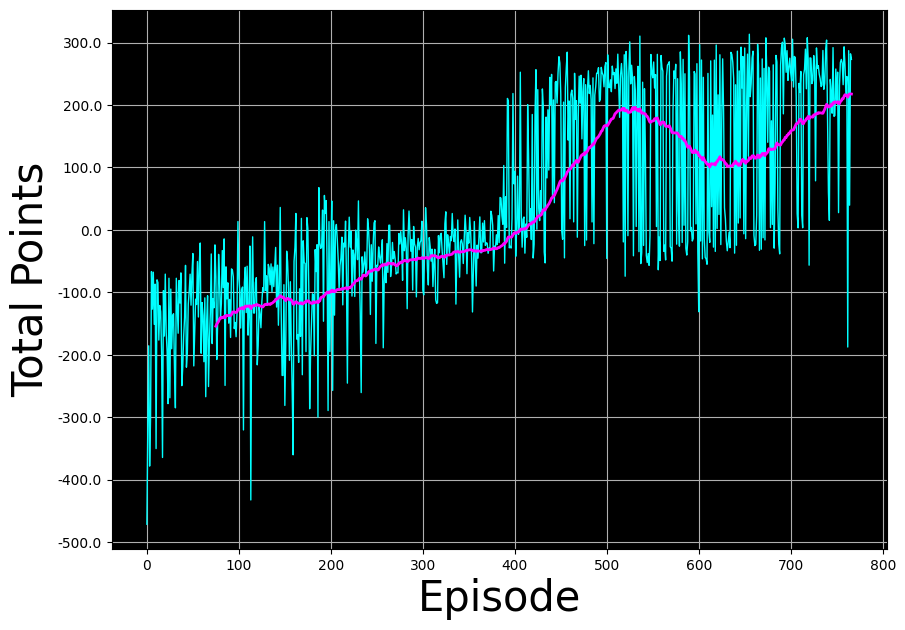

In [20]:
# Plot the total point history along with the moving average
plot_history(total_point_history)

# **10- See the Trained Agent In Action**

In [21]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In the cell below we create a video of our agent interacting with the Lunar Lander environment using the trained q_network.

In [22]:
filename = "/content/drive/MyDrive/coursera/Unsupervised Learning/Reinforcement Learning/lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
